# Vorticity & Wind Stress Curl

Compute surface relative vorticity and wind stress curl on the Arakawa C-grid,
with proper lateral boundary conditions via `fmask`.

On the C-grid, vorticity naturally lives on **F-points** (the corners of T-cells).
The `fmask` array encodes the lateral boundary condition: it equals `rn_shlat` at
coastal F-points (0 for free-slip, 2 for no-slip). Multiplying the raw curl by
`fmask` enforces the correct coastal vorticity.

For comparison with tracers (which live on T-points), we interpolate F-point
vorticity to T-points using fmask-weighted averaging of the 4 surrounding F-points.

Reference: [NEMO docs — Boundary Condition at the Coast](https://www.nemo-ocean.eu/doc/node58.html)

In [1]:
from pathlib import Path

import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

from gyre import load_output, load_mesh, interior_mask, gyre_map

plt.rcParams.update({"font.size": 16, "axes.titlesize": 18, "axes.labelsize": 14})

OUTPUT_DIR = Path("../output")

## Load data

Load U/V velocities, T-grid fields (wind stress), and mesh_mask (scale factors,
Coriolis, masks).

In [2]:
ds_u = load_output("*_grid_U.nc", OUTPUT_DIR)
ds_v = load_output("*_grid_V.nc", OUTPUT_DIR)
ds_t = load_output("*_grid_T.nc", OUTPUT_DIR)
mesh = load_mesh(OUTPUT_DIR)

interior = interior_mask(mesh.tmask.isel(nav_lev=0), border=2)

## Surface relative vorticity on F-points

On the Arakawa C-grid, the discrete curl is:

$$\zeta^f_{i,j} = \frac{1}{e_{1f}} \Delta_i v - \frac{1}{e_{2f}} \Delta_j u$$

where $\Delta_i v = v_{i+1,j} - v_{i,j}$ and $\Delta_j u = u_{i,j+1} - u_{i,j}$.

The lateral boundary condition is applied by multiplying by `fmask`:
$\zeta^f_{\text{bc}} = \zeta^f \times f_{\text{mask}}$.
For free-slip (`rn_shlat=0`), fmask is 0 at coasts → zero coastal vorticity.
For no-slip (`rn_shlat=2`), fmask is 2 at coasts → finite coastal vorticity.

In [3]:
# Surface velocities — fill NaN over land with 0 for clean differencing
u_sfc = ds_u["vozocrtx"].isel(nav_lev=0).fillna(0)
v_sfc = ds_v["vomecrty"].isel(nav_lev=0).fillna(0)

# Scale factors at f-points
e1f = mesh["e1f"]
e2f = mesh["e2f"]

# Finite differences: v.diff('x') and u.diff('y') both land on f-points
# v.diff('x') loses 1 in x, u.diff('y') loses 1 in y
# Trim to common f-point grid and reset integer coords (diff shifts them)
dvdx_raw = v_sfc.diff("x")
dudy_raw = u_sfc.diff("y")

nx_f = dvdx_raw.sizes["x"]  # N-1 in x
ny_f = dudy_raw.sizes["y"]  # N-1 in y

def _reset_xy(da, nx, ny):
    """Trim to (nx, ny) and reset x/y to integer coords."""
    return da.isel(x=slice(None, nx), y=slice(None, ny)).assign_coords(
        x=range(nx), y=range(ny),
    )

dvdx = _reset_xy(dvdx_raw, nx_f, ny_f) / _reset_xy(e1f, nx_f, ny_f)
dudy = _reset_xy(dudy_raw, nx_f, ny_f) / _reset_xy(e2f, nx_f, ny_f)

raw_vort = dvdx - dudy

# Apply lateral BC via fmask
fmask_sfc = _reset_xy(mesh["fmask"].isel(nav_lev=0), nx_f, ny_f)
vort_f = raw_vort * fmask_sfc

print(f"F-point vorticity grid: {dict(vort_f.sizes)}")

F-point vorticity grid: {'time_counter': 1800, 'y': 101, 'x': 151}


## F-point → T-point interpolation

To compare vorticity with T-grid tracers (e.g. for budget analysis), we average
the 4 F-points surrounding each T-point, weighted by `fmask`:

$$\zeta^t_{i,j} = \frac{\sum_{k \in \text{corners}} f_{\text{mask},k} \, \zeta^f_k}
{\sum_{k \in \text{corners}} f_{\text{mask},k}}$$

The 4 F-corners of T(i,j) are F(i-1,j-1), F(i,j-1), F(i-1,j), F(i,j).
The fmask weighting ensures that land F-points (fmask=0) are excluded and
coastal F-points contribute with their correct `rn_shlat` weight.

In [4]:
def f_to_t(field_f, fmask_f):
    """fmask-weighted average of 4 surrounding F-points to T-point.

    The 4 F-corners of T(i,j) are at F-grid indices:
      (i-1, j-1), (i, j-1), (i-1, j), (i, j)

    After gathering with slicing, the result grid is 1 cell smaller
    in each direction than field_f.
    """
    # Gather the 4 corners by shifting
    sw = field_f.isel(x=slice(None, -1), y=slice(None, -1))  # F(i-1, j-1)
    se = field_f.isel(x=slice(1, None), y=slice(None, -1))   # F(i,   j-1)
    nw = field_f.isel(x=slice(None, -1), y=slice(1, None))   # F(i-1, j)
    ne = field_f.isel(x=slice(1, None), y=slice(1, None))     # F(i,   j)

    msw = fmask_f.isel(x=slice(None, -1), y=slice(None, -1))
    mse = fmask_f.isel(x=slice(1, None), y=slice(None, -1))
    mnw = fmask_f.isel(x=slice(None, -1), y=slice(1, None))
    mne = fmask_f.isel(x=slice(1, None), y=slice(1, None))

    # Reset coords so arithmetic aligns positionally
    def _reset(da):
        return da.assign_coords(x=range(da.sizes["x"]), y=range(da.sizes["y"]))

    sw, se, nw, ne = [_reset(c) for c in (sw, se, nw, ne)]
    msw, mse, mnw, mne = [_reset(c) for c in (msw, mse, mnw, mne)]

    weights = msw + mse + mnw + mne
    values = sw * msw + se * mse + nw * mnw + ne * mne
    return xr.where(weights > 0, values / weights, 0.0)


vort_t = f_to_t(vort_f, fmask_sfc)

# Rossby number: normalise by Coriolis on T-grid
# Trim ff_t to match vort_t (which is smaller than the full grid)
ff_t = mesh["ff_t"].isel(
    x=slice(1, 1 + vort_t.sizes["x"]),
    y=slice(1, 1 + vort_t.sizes["y"]),
)
ff_t = ff_t.assign_coords(x=range(ff_t.sizes["x"]), y=range(ff_t.sizes["y"]))

# Interior mask for the T-subgrid
tmask_sub = mesh["tmask"].isel(
    nav_lev=0,
    x=slice(1, 1 + vort_t.sizes["x"]),
    y=slice(1, 1 + vort_t.sizes["y"]),
)
tmask_sub = tmask_sub.assign_coords(x=range(tmask_sub.sizes["x"]), y=range(tmask_sub.sizes["y"]))
interior_sub = interior_mask(tmask_sub, border=2)

rossby_t = xr.where(ff_t != 0, vort_t / ff_t, 0.0).where(interior_sub)

print(f"T-point vorticity grid: {dict(rossby_t.sizes)}")
print(f"Rossby number range: [{float(rossby_t.min()):.4f}, {float(rossby_t.max()):.4f}]")

T-point vorticity grid: {'y': 100, 'x': 150, 'time_counter': 1800}


Rossby number range: [-0.1155, 0.0708]


## Wind stress curl

Wind stress is stored on the T-grid in IOIPSL output (`sozotaux`, `sometauy`).
Internally, NEMO has $\tau_x$ on U-points and $\tau_y$ on V-points, but the
IOIPSL diagnostics interpolate to T before writing. Computing the curl from
T-point stress introduces a ~half-cell offset — an acceptable approximation
for diagnostics.

We apply the same fmask scaling and F→T interpolation as for vorticity.

In [5]:
tau_x = ds_t["sozotaux"].fillna(0)
tau_y = ds_t["sometauy"].fillna(0)

# Curl on F-points (approximate — stress is on T, not U/V)
dtauydx_raw = tau_y.diff("x")
dtauxdy_raw = tau_x.diff("y")

nx_tf = dtauydx_raw.sizes["x"]  # N-1 in x
ny_tf = dtauxdy_raw.sizes["y"]  # N-1 in y

dtauydx = _reset_xy(dtauydx_raw, nx_tf, ny_tf) / _reset_xy(e1f, nx_tf, ny_tf)
dtauxdy = _reset_xy(dtauxdy_raw, nx_tf, ny_tf) / _reset_xy(e2f, nx_tf, ny_tf)

fmask_tau = _reset_xy(mesh["fmask"].isel(nav_lev=0), nx_tf, ny_tf)
curl_tau_f = (dtauydx - dtauxdy) * fmask_tau

# F→T average
curl_tau_t = f_to_t(curl_tau_f, fmask_tau)

# Match to same T-subgrid as vorticity for plotting
nx_common = min(curl_tau_t.sizes["x"], rossby_t.sizes["x"])
ny_common = min(curl_tau_t.sizes["y"], rossby_t.sizes["y"])
curl_tau_t = curl_tau_t.isel(x=slice(None, nx_common), y=slice(None, ny_common))

print(f"Wind stress curl grid: {dict(curl_tau_t.sizes)}")

Wind stress curl grid: {'y': 100, 'x': 150, 'time_counter': 1800}


## Time-mean vorticity and curl(τ)

Two-panel map:
- **Left**: time-mean ζ/f (Rossby number) on the T-grid
- **Right**: time-mean curl(τ)/(ρ₀f) on the T-grid — the Sverdrup-relevant
  normalisation showing the wind-driven forcing pattern

Saved figures/vorticity_curl_tau.png


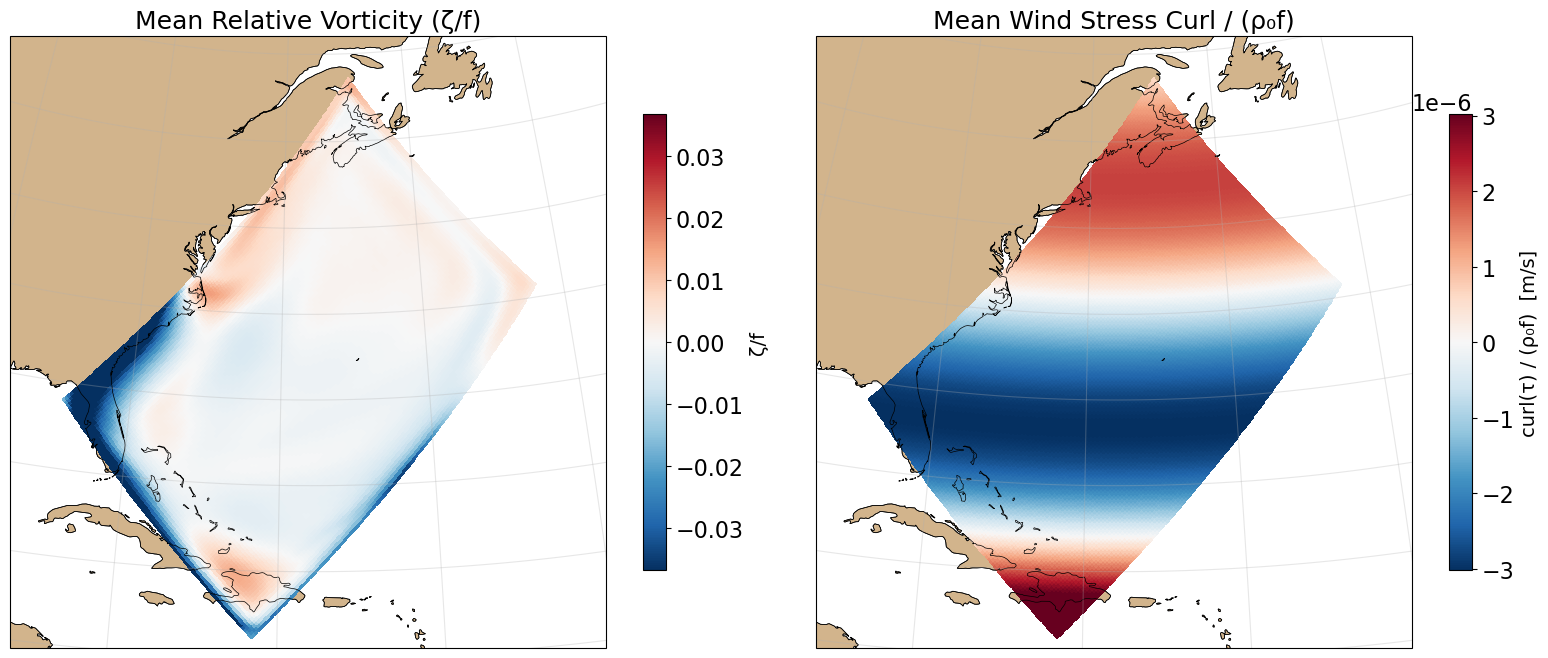

In [6]:
# Time means
rossby_mean = rossby_t.mean("time_counter")
curl_tau_mean = curl_tau_t.mean("time_counter")

# Normalise curl(tau) by rho0 * f for Sverdrup transport comparison
rho0 = 1026.0  # kg/m³, NEMO reference density
ff_t_common = ff_t.isel(x=slice(None, nx_common), y=slice(None, ny_common))
interior_common = interior_sub.isel(x=slice(None, nx_common), y=slice(None, ny_common))

curl_tau_norm = xr.where(
    ff_t_common != 0,
    curl_tau_mean / (rho0 * ff_t_common),
    0.0,
).where(interior_common)

# Coordinates for plotting — T-grid lon/lat at matching positions
lon_t = mesh["glamt"].isel(
    x=slice(1, 1 + nx_common),
    y=slice(1, 1 + ny_common),
).values
lat_t = mesh["gphit"].isel(
    x=slice(1, 1 + nx_common),
    y=slice(1, 1 + ny_common),
).values

# Symmetric colour limits
s = dict(x=slice(3, -3), y=slice(3, -3))
vmax_ro = float(np.abs(rossby_mean.isel(**s)).quantile(0.98))
vmax_sv = float(np.abs(curl_tau_norm.isel(**s)).quantile(0.98))

proj = ccrs.Stereographic(central_longitude=-68, central_latitude=32)
fig, axes = plt.subplots(
    1, 2, figsize=(16, 7),
    subplot_kw=dict(projection=proj),
)

# Left: Rossby number
ax = axes[0]
gyre_map(ax=ax, ds=ds_t)
pcm0 = ax.pcolormesh(
    lon_t, lat_t, rossby_mean.values,
    shading="auto", cmap="RdBu_r",
    vmin=-vmax_ro, vmax=vmax_ro,
    transform=ccrs.PlateCarree(),
)
fig.colorbar(pcm0, ax=ax, label="ζ/f", shrink=0.7)
ax.set_title("Mean Relative Vorticity (ζ/f)")

# Right: curl(tau) / (rho0 * f)
ax = axes[1]
gyre_map(ax=ax, ds=ds_t)
pcm1 = ax.pcolormesh(
    lon_t, lat_t, curl_tau_norm.values,
    shading="auto", cmap="RdBu_r",
    vmin=-vmax_sv, vmax=vmax_sv,
    transform=ccrs.PlateCarree(),
)
fig.colorbar(pcm1, ax=ax, label="curl(τ) / (ρ₀f)  [m/s]", shrink=0.7)
ax.set_title("Mean Wind Stress Curl / (ρ₀f)")

fig.tight_layout()
fig.savefig("../figures/vorticity_curl_tau.png", dpi=150, bbox_inches="tight")
print("Saved figures/vorticity_curl_tau.png")